# Predicting Long-Lived Bugs

# 1. Introduction 

This first experiment used a dataset with 7935 bug reports extracted from Eclipse Bugzilla Tracking System. The table below shows the evaluation performance metrics yielded.

## 1.1 Data Exploration

In [77]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

%matplotlib inline 

plt.style.use('default')
sns.set_context("paper")

In [78]:
reports_file = '../datasets/eclipse_bug_reports.csv'

!echo "Header of reports file"
!head -n 2 $reports_file

!echo "\nNumber of reports in the file:"
!wc -l $reports_file


Header of reports file
bug_id,creation_date,component_name,product_name,short_description,long_description,assignee_name,reporter_name,resolution_category,resolution_code,status_category,status_code,update_date,quantity_of_votes,quantity_of_comments,resolution_date,days_to_resolve,severity_category,severity_code
COMMUNITY-455431,2014-12-17,Servers,COMMUNITY,Need SSH access to build.eclipse.org for uwe.stieber@windriver.com,I'm a committer on the tools.cdt.tcf project and got asked to take over some release engineering stuff from my project lead Martin Oberhuber. In order to do this I need to be able to SSH login to build.eclipse.org. Please re-enable the real shell access for my user (Uwe Stieber uwe.stieber@windriver.com).,webmaster,uwe.st,fixed,1,resolved,4,2014-12-17,0,3,2014-12-17,0,normal,2

Number of reports in the file:
  197505 ../datasets/eclipse_bug_reports.csv


In [79]:
reports = pd.read_csv(reports_file)
reports = reports.loc[(reports['days_to_resolve'] >= 0) & (reports['days_to_resolve'] <= 730)  , ]
reports['resolution_code'] = reports['resolution_code'].astype('category')
reports['status_category'] = reports['status_category'].astype('category')
reports['severity_code'] = reports['severity_code'].astype('category')
reports['short_description_length'] = reports['short_description'].str.len()
reports['long_description_length'] = reports['long_description'].str.len()
reports.head(5)

,bug_id,creation_date,component_name,product_name,short_description,long_description,assignee_name,reporter_name,resolution_category,resolution_code,...,status_code,update_date,quantity_of_votes,quantity_of_comments,resolution_date,days_to_resolve,severity_category,severity_code,short_description_length,long_description_length
0,COMMUNITY-455431,2014-12-17,Servers,COMMUNITY,Need SSH access to build.eclipse.org for uwe.s...,I'm a committer on the tools.cdt.tcf project a...,webmaster,uwe.st,fixed,1,...,4,2014-12-17,0,3,2014-12-17,0,normal,2,66.0,306.0
1,JDT-31738,2003-02-12,UI,JDT,Weird behavior setting project libraries,Open the properties for a project then Java Bu...,martinae,bogofilter+eclipse.org,fixed,1,...,4,2003-02-18,0,4,2003-02-18,6,normal,2,40.0,654.0
2,ORION-389073,2012-09-07,Git,ORION,Pull gives me an auth fail error without promp...,With the latest changes in git credentials (to...,simon_kaegi,susan,fixed,1,...,4,2012-09-12,0,7,2012-09-12,5,major,4,66.0,236.0
3,JETTY-306226,2010-03-17,client,JETTY,HttpClient should allow changing to the keysto...,(Originally JETTY-1190 @ Codehaus JIRA)\n\nCur...,mgorovoy,mgorovoy,fixed,1,...,4,2010-10-13,0,3,2010-05-12,56,normal,2,68.0,182.0
4,WTP_SOURCE_EDITING-185183,2007-05-02,wst.xsd,WTP_SOURCE_EDITING,Update copyright headers for WSDL and XSD comp...,Update copyright headers for WSDL and XSD comp...,kchong,kchong,fixed,1,...,6,2007-07-05,0,4,2007-05-02,0,normal,2,52.0,52.0


### Basic Statistics

In [80]:
reports.describe(include="all")

,bug_id,creation_date,component_name,product_name,short_description,long_description,assignee_name,reporter_name,resolution_category,resolution_code,...,status_code,update_date,quantity_of_votes,quantity_of_comments,resolution_date,days_to_resolve,severity_category,severity_code,short_description_length,long_description_length
count,11246,11246,11246,11246,11243,11063,11246,11246,11246,11246.0,...,11246.000000,11246,11246.000000,11246.000000,11246,11246.000000,11246,11246.0,11243.000000,11063.000000
unique,11246,4183,631,188,11200,10903,1609,3082,1,1.0,...,NaN,3770,NaN,NaN,4064,NaN,6,5.0,NaN,NaN
top,CDT-137970,2001-10-10,UI,PLATFORM,Accessibility,,webmaster,david_williams,fixed,1.0,...,NaN,2016-05-05,NaN,NaN,2017-05-10,NaN,normal,2.0,NaN,NaN
freq,1,37,1302,1533,5,90,263,140,11246,11246.0,...,NaN,255,NaN,NaN,15,NaN,8876,9261.0,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.652321,NaN,0.025698,5.706829,NaN,68.605460,NaN,NaN,56.477719,923.390762
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.937655,NaN,0.351782,5.811217,NaN,131.934076,NaN,NaN,21.433532,2552.910363
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.000000,NaN,0.000000,1.000000,NaN,0.000000,NaN,NaN,2.000000,1.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.000000,NaN,0.000000,3.000000,NaN,1.000000,NaN,NaN,42.000000,188.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.000000,NaN,0.000000,4.000000,NaN,9.000000,NaN,NaN,54.000000,354.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.000000,NaN,0.000000,6.000000,NaN,63.000000,NaN,NaN,69.000000,721.500000


### Features Correlation

In [81]:
reports[['days_to_resolve', 'quantity_of_comments', 'quantity_of_votes'
         , 'short_description_length', 'long_description_length']].corr()

,days_to_resolve,quantity_of_comments,quantity_of_votes,short_description_length,long_description_length
days_to_resolve,1.000000,0.160134,0.074449,0.022745,-0.000191
quantity_of_comments,0.160134,1.000000,0.218668,0.016938,0.041756
quantity_of_votes,0.074449,0.218668,1.000000,0.010403,0.013195
short_description_length,0.022745,0.016938,0.010403,1.000000,0.025581
long_description_length,-0.000191,0.041756,0.013195,0.025581,1.000000


### Severity Level Analysis

In [82]:
top_severity_level = reports.groupby('severity_category').severity_category.agg(['count'])
top_severity_level = top_severity_level.sort_values('count', ascending=False)[0:10]
top_severity_level

,count
severity_category,
normal,8876
major,1167
critical,425
minor,385
blocker,254
trivial,139


Text(0.5, 0, '')

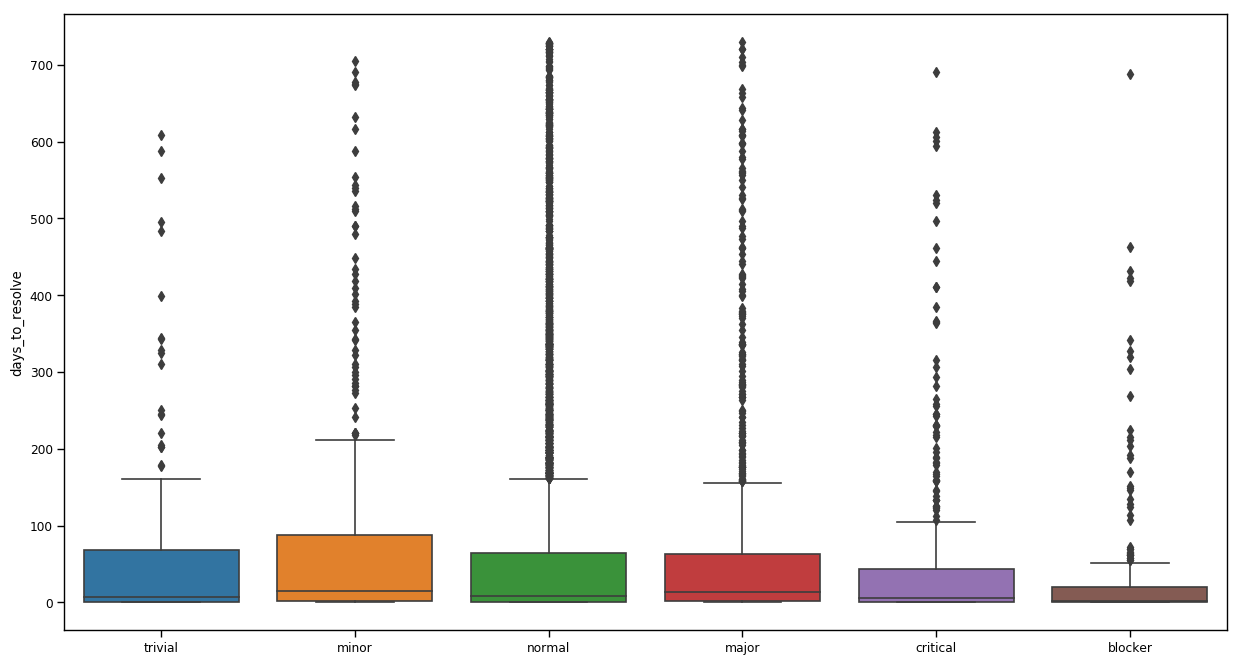

In [83]:
fig, ax = plt.subplots(figsize=(15,8))
g = sns.boxplot(data=reports, x="severity_category", y="days_to_resolve"
                , order=['trivial', 'minor', 'normal', 'major', 'critical', 'blocker']
                , showfliers=True)
plt.xlabel("")

### Reporters Analysis

In [84]:
number_of_reports   = reports['bug_id'].count()
number_of_reporters = reports['reporter_name'].nunique()
print("%s reporters reported %s bugs." % (number_of_reporters, number_of_reports))

3082 reporters reported 11246 bugs.


In [85]:
top_10_reporters = reports.groupby('reporter_name').reporter_name.agg(['count'])
top_10_reporters = top_10_reporters.sort_values('count', ascending=False)[0:10]
top_10_reporters

,count
reporter_name,
david_williams,140
john.arthorne,110
eclipse,109
wayne.beaton,96
markus.kell.r,95
pascal,84
daniel_megert,83
lchen,79
xwang,76


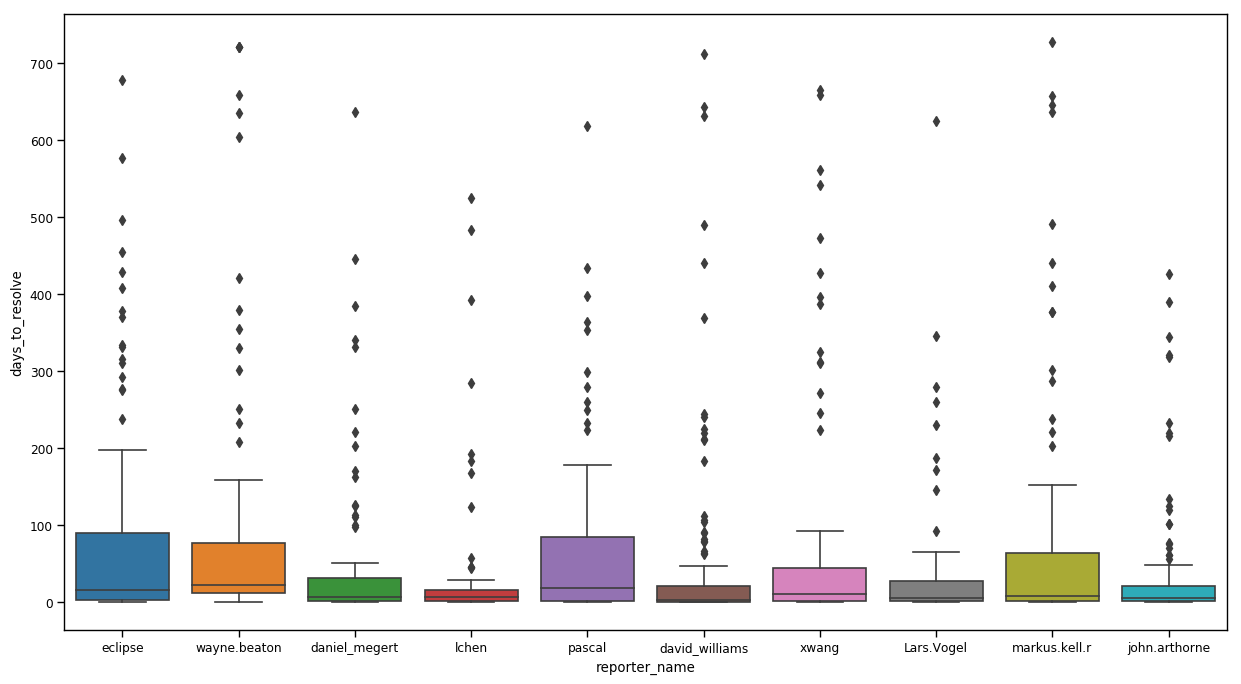

In [86]:
fig, ax = plt.subplots(figsize=(15,8))
sns.boxplot(data=reports[reports['reporter_name'].isin(top_10_reporters.index)]
            , x="reporter_name"
            , y="days_to_resolve"
            , showfliers=True)

### Assignee Analysis

In [87]:
top_10_assignee = reports.groupby('assignee_name').assignee_name.agg(['count'])
top_10_assignee = top_10_assignee.sort_values('count', ascending=False)[0:10]
top_10_assignee

,count
assignee_name,
webmaster,263
rap-inbox,128
pde-ui-inbox,87
Silenio_Quarti,86
eclipse,85
emo,83
david_williams,80
john.arthorne,79
tmf.xtext-inbox,79


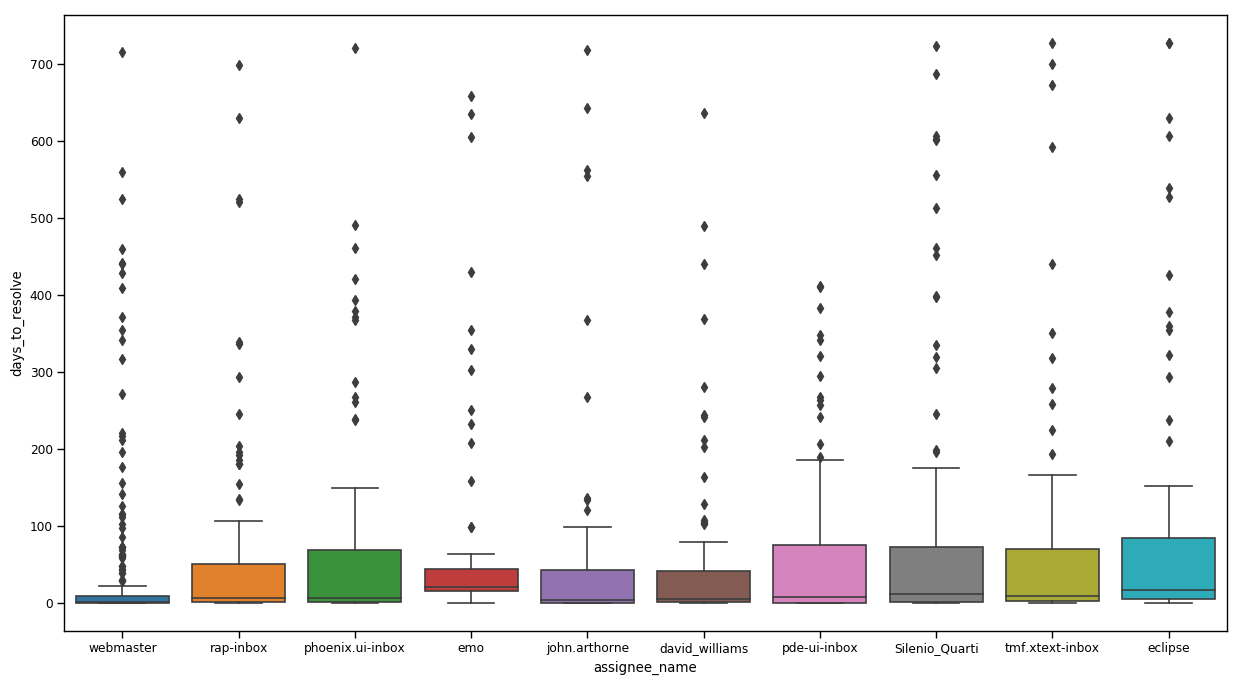

In [88]:
fig, ax = plt.subplots(figsize=(15,8))
sns.boxplot(data=reports[reports['assignee_name'].isin(top_10_assignee.index)]
            , x="assignee_name"
            , y="days_to_resolve"
            , showfliers=True)

### Component Analysis

In [89]:
top_10_component = reports.groupby('component_name').component_name.agg(['count'])
top_10_component = top_10_component.sort_values('count', ascending=False)[0:10]
top_10_component

,count
component_name,
UI,1302
Core,866
SWT,426
TPTP,251
Releng,220
General,216
cdt-core,186
Client,171
jst.j2ee,157


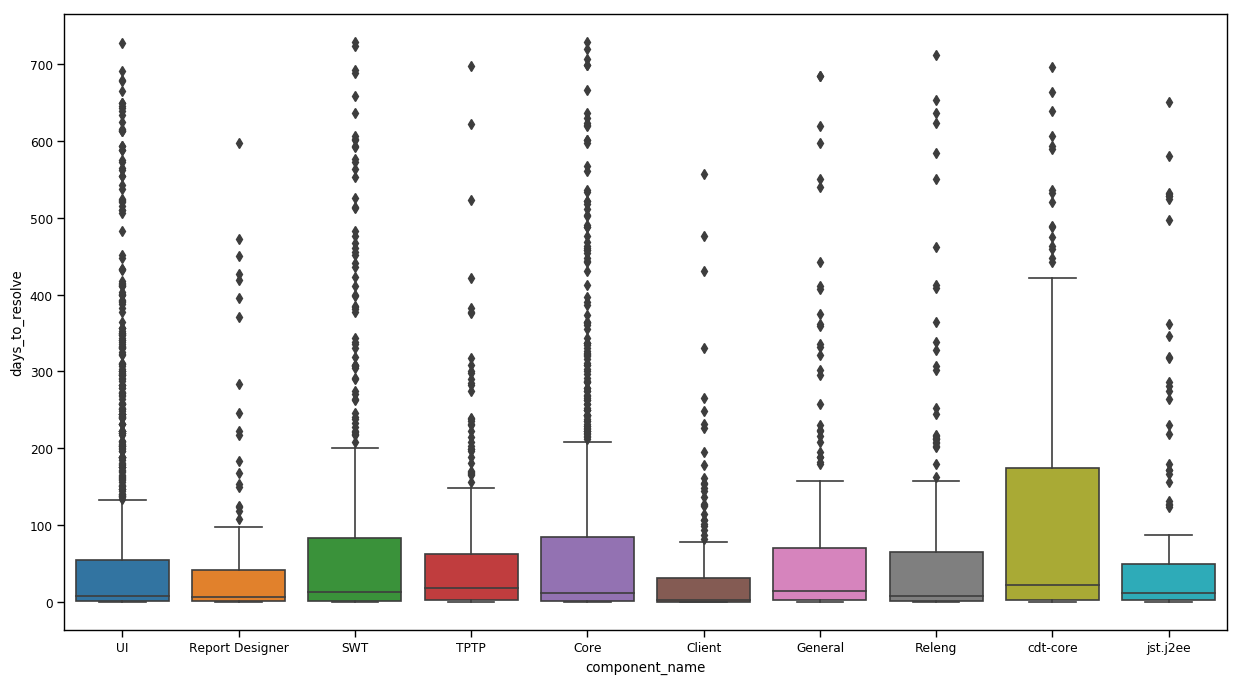

In [90]:

fig, ax = plt.subplots(figsize=(15,8))
sns.boxplot(data=reports[reports['component_name'].isin(top_10_component.index)]
            , x="component_name"
            , y="days_to_resolve"
            , showfliers=True)

## Features Analysis

In [91]:
features_file = '../scripts/output/20190123183632-long_description-features.csv'
!echo "Header of features file"
head_features_file = !head -n 2 $features_file
print(head_features_file)

!echo "\nNumber of features in the file:"
number_of_lines = !wc -l $features_file
number_of_lines


Header of features file
['bug_id,days_to_resolve,action,activ,actual,add,allow,also,alway,api,appear,attach,attribut,avail,birt,bug,build,bundl,button,call,can,case,caus,chang,chart,check,class,click,close,code,com,comment,compil,configur,connect,contain,content,context,core,correct,creat,current,data,default,delet,depend,descript,diagram,dialog,display,document,dollar,dot,download,eclips,edit,editor,element,emf,error,event,exampl,except,exist,expect,extens,fail,featur,field,file,first,fix,folder,follow,function,generat,get,git,help,html,http,https,icon,imag,implement,import,includ,inform,initi,instal,instead,intern,issu,item,jar,java,jdt,job,just,label,launch,librari,like,line,link,list,log,look,make,menu,messag,method,miss,model,move,must,name,need,new,now,null,number,object,one,open,option,org,packag,page,paramet,part,patch,path,platform,pleas,plugin,point,possibl,prefer,problem,project,properti,provid,public,refer,releas,remov,report,repositori,reproduc,requir,resourc,result,return

['   10888 ../scripts/output/20190123183632-long_description-features.csv']

In [92]:
features = pd.read_csv(features_file)
features.head(10)

,bug_id,days_to_resolve,action,activ,actual,add,allow,also,alway,api,...,version,view,web,widget,will,window,wizard,work,workspac,xml
0,4DIAC-490689,655,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0000,0.0,0.000000,0.0,0.0
1,4DIAC-491352,646,0.0,0.000000,0.0,0.346563,0.0,0.359314,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0000,0.0,0.000000,0.0,0.0
2,4DIAC-494587,77,0.0,0.336416,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.000000,0.227804,0.0,0.0,0.0,0.0000,0.0,0.000000,0.0,0.0
3,4DIAC-494882,0,0.0,0.000000,0.0,0.000000,0.0,0.179657,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0000,0.0,0.000000,0.0,0.0
4,4DIAC-495363,60,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0000,0.0,0.000000,0.0,0.0
5,4DIAC-495365,68,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.070816,0.000000,0.0,0.0,0.0,0.0786,0.0,0.000000,0.0,0.0
6,4DIAC-495644,0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0000,0.0,0.000000,0.0,0.0
7,4DIAC-495646,8,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.000000,0.162717,0.0,0.0,0.0,0.0000,0.0,0.152136,0.0,0.0
8,4DIAC-498878,2,0.0,0.000000,0.0,0.000000,0.0,0.163325,0.0,0.0,...,0.157727,0.000000,0.0,0.0,0.0,0.0000,0.0,0.000000,0.0,0.0
9,4DIAC-508017,0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0000,0.0,0.000000,0.0,0.0


In [93]:
features.describe()

,days_to_resolve,action,activ,actual,add,allow,also,alway,api,appear,...,version,view,web,widget,will,window,wizard,work,workspac,xml
count,10887.000000,10887.000000,10887.000000,10887.000000,10887.000000,10887.000000,10887.000000,10887.000000,10887.000000,10887.000000,...,10887.000000,10887.000000,10887.000000,10887.000000,10887.000000,10887.000000,10887.000000,10887.000000,10887.000000,10887.000000
mean,69.452007,0.006424,0.005445,0.005805,0.011133,0.005559,0.008029,0.006547,0.006544,0.006284,...,0.009907,0.013399,0.006328,0.007566,0.013776,0.007212,0.005821,0.010692,0.005664,0.008416
std,132.827818,0.040539,0.043381,0.027869,0.051565,0.044227,0.036835,0.035170,0.048802,0.037489,...,0.052599,0.058474,0.049183,0.038343,0.045070,0.039906,0.042181,0.046521,0.037216,0.045183
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,64.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,729.000000,0.779894,1.261559,0.494464,1.155209,1.652584,0.898285,1.006703,1.623510,0.624879,...,1.734996,1.139018,2.429517,0.891059,0.895240,0.770284,1.605883,1.597432,1.429806,0.821679


In [94]:
features.corr().head(10)

,days_to_resolve,action,activ,actual,add,allow,also,alway,api,appear,...,version,view,web,widget,will,window,wizard,work,workspac,xml
days_to_resolve,1.000000,0.002467,-0.004482,-0.003885,-0.002076,0.006095,0.001940,-0.006284,-0.009580,0.023309,...,-0.010261,0.017248,-0.001955,-0.007942,-0.000061,0.007864,-0.002842,-0.000253,-0.014774,0.000608
action,0.002467,1.000000,0.005641,-0.016802,0.020574,0.004520,0.015495,-0.007656,-0.005206,0.000700,...,-0.018700,0.039319,-0.014609,0.040344,0.009706,0.003461,0.002024,0.012069,-0.003079,-0.015393
activ,-0.004482,0.005641,1.000000,-0.013193,-0.014480,0.036843,0.001106,-0.001468,-0.012609,0.011772,...,-0.015831,0.056313,-0.007362,-0.003260,-0.002526,0.006938,-0.006021,0.050718,-0.011745,-0.003887
actual,-0.003885,-0.016802,-0.013193,1.000000,0.007985,-0.018632,-0.019796,0.005652,-0.021471,0.009267,...,-0.013889,-0.004320,0.016673,-0.034883,-0.017551,-0.018236,-0.004737,0.019648,-0.018709,0.017842
add,-0.002076,0.020574,-0.014480,0.007985,1.000000,0.008957,0.002884,-0.016593,0.001889,-0.009044,...,-0.017270,-0.002077,-0.005377,-0.028965,0.005663,-0.006207,0.013890,-0.016414,-0.003538,-0.003013
allow,0.006095,0.004520,0.036843,-0.018632,0.008957,1.000000,0.048111,-0.015812,0.007696,-0.012778,...,0.002735,0.011856,-0.002597,-0.019047,0.028088,-0.013300,0.008695,-0.011531,-0.001690,-0.019022
also,0.001940,0.015495,0.001106,-0.019796,0.002884,0.048111,1.000000,-0.007906,0.000491,0.007257,...,-0.002327,0.012233,-0.012728,-0.031637,0.006342,-0.017276,-0.002768,0.011388,-0.017619,-0.004999
alway,-0.006284,-0.007656,-0.001468,0.005652,-0.016593,-0.015812,-0.007906,1.000000,-0.013559,-0.001892,...,0.010416,0.001207,0.000491,-0.002000,-0.010278,0.028484,0.005998,-0.015019,-0.002491,0.000062
api,-0.009580,-0.005206,-0.012609,-0.021471,0.001889,0.007696,0.000491,-0.013559,1.000000,-0.020783,...,0.009844,-0.025901,-0.006479,-0.012132,0.011896,-0.018145,-0.015756,-0.015002,0.000275,-0.008597
appear,0.023309,0.000700,0.011772,0.009267,-0.009044,-0.012778,0.007257,-0.001892,-0.020783,1.000000,...,-0.013759,0.079131,-0.002350,-0.022812,-0.017388,0.027461,0.034211,0.001234,-0.010694,-0.020302


In [95]:
top_10_features = features.loc[:, 'action':'xml'].sum(axis=0).to_frame('sum')
top_10_features = top_10_features.sort_values(by='sum', ascending=False)[0:15]
top_10_features

,sum
eclips,371.323280
org,370.692615
java,366.443378
bug,248.075314
use,204.827094
file,204.141903
project,203.434604
creat,192.789337
test,183.820746
build,182.578951


In [96]:
features['days_to_resolve'].value_counts().to_frame().head(10)

,days_to_resolve
0,2114
1,1028
2,480
3,388
4,288
6,280
7,277
5,259
8,198
14,144


/Users/luiz/apps/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/luiz/apps/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


The cumulative variance of the first two principal components is [0.0231  0.0376  0.04892 0.05935 0.069   0.07842 0.08747 0.09592 0.10424
 0.11231 0.12021 0.1279  0.13543 0.14271 0.14994 0.15701 0.16395 0.17088
 0.17772 0.18452 0.1913  0.19799 0.2046  0.2112  0.21773 0.2242  0.23061
 0.23697 0.24331 0.24961 0.25586 0.26209 0.26831 0.2745  0.28061 0.28667
 0.29272 0.29874 0.3047  0.31063 0.31652 0.32238 0.32822 0.33403 0.3398
 0.34556 0.35129 0.357   0.3627  0.36837 0.37401 0.37964 0.38523 0.39082
 0.39639 0.40194 0.40747 0.41296 0.41843 0.4239  0.42933 0.43474 0.44011
 0.44548 0.45082 0.45614 0.46142 0.4667  0.47196 0.4772  0.48243 0.48763
 0.49282 0.49798 0.50314 0.50827 0.51338 0.51846 0.52352 0.52858 0.5336
 0.53862 0.54362 0.5486  0.55358 0.55854 0.56349 0.56842 0.57332 0.57821
 0.58308 0.58794 0.59278 0.5976  0.6024  0.60718 0.61194 0.6167  0.62144
 0.62616 0.63087 0.63557 0.64024 0.64489 0.64953 0.65416 0.65877 0.66336
 0.66793 0.67249 0.67704 0.68157 0.68608 0.69058 0.69506 0.69

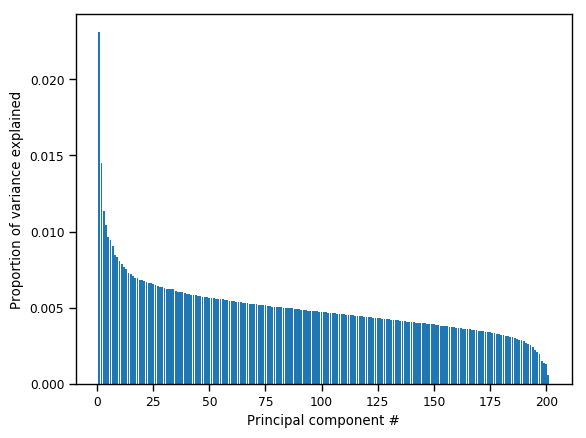

In [97]:
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features.loc[:, 'days_to_resolve':'xml'])

pca = PCA()
pca = pca.fit(features_scaled)


plt.bar(range(1, pca.n_components_ + 1),  pca.explained_variance_ratio_)
plt.xlabel('Principal component #')
plt.ylabel('Proportion of variance explained')
#plt.xticks([1, 2, 3])

# Compute the cumulative proportion of variance explained by the first two principal components
two_first_comp_var_exp = pca.explained_variance_ratio_.cumsum()
print("The cumulative variance of the first two principal components is {}"
      .format(np.round(two_first_comp_var_exp,5)))



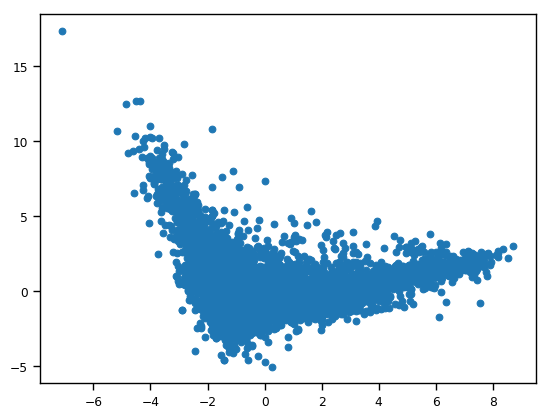

In [98]:
pca = PCA()
p_comps = pca.fit_transform(features_scaled)

# Extract the first and second component to use for the scatter plot
p_comp1 = p_comps[:, 0]
p_comp2 = p_comps[:, 1]

# Plot the first two principal components in a scatter plot
plt.scatter(p_comp1, p_comp2)

[]

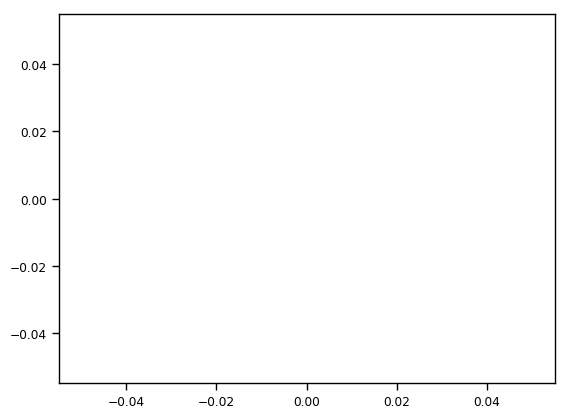

In [99]:


# A loop will be used to plot the explanatory power for up to 10 KMeans clusters
ks = range(1, 10)
inertias = []
for k in ks:
    # Initialize the KMeans object using the current number of clusters (k)
    km = KMeans(n_clusters=k, random_state=8)
    # Fit the scaled features to the KMeans object
    km.fit(features_scaled)
    # Append the inertia for `km` to the list of inertias
    inertias.append(km)
    
# Plot the results in a line plot
plt.plot(kind='scatter', x=ks, y=inertias, marker='o')

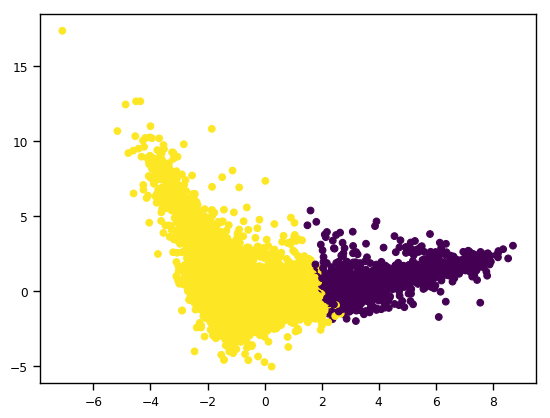

In [100]:
# Create a KMeans object with 3 clusters, use random_state=8 
km = KMeans(n_clusters=2, random_state=8)

# Fit the data to the `km` object
km.fit(features_scaled)

# Create a scatter plot of the first two principal components
# and color it according to the KMeans cluster assignment 
plt.scatter(p_comps[:, 0], p_comps[:, 1], c=km.labels_)

## 1.2 Experiment Analysis

In [101]:
metrics_file = '../scripts/output/20190123183500-predicting-metrics.csv'
!echo "Header of metrics file:"
metrics_file_head = !head -n 1 $metrics_file
print(metrics_file_head)

!echo "\nNumber of lines in the metrics file:"
number_of_lines = !wc -l $metrics_file
number_of_lines

Header of metrics file:
['dataset,classifier,resampling,distribution,threshold,train_size,train_size_class_0,train_size_class_1,test_size,test_size_class_0,test_size_class_1,feature,n_terms,tp,fp,tn,fn,acc_class_0,acc_class_1,balanced_acc,precision,recall,fmeasure']

Number of lines in the metrics file:


['     145 ../scripts/output/20190123183500-predicting-metrics.csv']

In [102]:
results = pd.read_csv(metrics_file)

# filling missing data
mean_of_acc1 = results['acc_class_1'].mean()
results['acc_class_1'] = results.acc_class_1.fillna(mean_of_acc1)
results['balanced_acc'] = results.balanced_acc.fillna((results.acc_class_0 + results.acc_class_1) / 2)

# updating data 
results.loc[results['classifier'] == 'knn', 'classifier'] = 'KNN'
results.loc[results['classifier'] == 'rf', 'classifier']  = 'Random Forest'
results.loc[results['classifier'] == 'svmRadial', 'classifier'] = 'SVM'
features = ['long_description','short_long_description', 'short_description']
results = results[results.feature.isin(features)]
results.tail()

,dataset,classifier,resampling,distribution,threshold,train_size,train_size_class_0,train_size_class_1,test_size,test_size_class_0,...,tp,fp,tn,fn,acc_class_0,acc_class_1,balanced_acc,precision,recall,fmeasure
139,Eclipse,SVM,cv52,balanced,28,4080,2040,2040,1358,679,...,366,289,313,390,0.558779,0.445235,0.502007,0.558779,0.484127,0.518781
140,Eclipse,SVM,cv52,balanced,36,4080,2040,2040,1358,679,...,378,327,301,352,0.536170,0.460949,0.498560,0.536170,0.517808,0.526829
141,Eclipse,SVM,cv52,balanced,44,4080,2040,2040,1358,679,...,357,310,322,369,0.535232,0.465991,0.500612,0.535232,0.491736,0.512563
142,Eclipse,SVM,cv52,balanced,52,4080,2040,2040,1358,679,...,373,287,306,392,0.565152,0.438395,0.501773,0.565152,0.487582,0.523509
143,Eclipse,SVM,cv52,balanced,60,4080,2040,2040,1358,679,...,353,297,326,382,0.543077,0.460452,0.501764,0.543077,0.480272,0.509747


### Analysis of Results

In [103]:
# calculating ratio between classes.
results['total_ratio_class_0'] = (results['train_size_class_0'] + results['test_size_class_0']) / (results['train_size']+results['test_size']) 
results['total_ratio_class_1'] = (results['train_size_class_1'] + results['test_size_class_1']) / (results['train_size']+results['test_size']) 
results['train_ratio_class_0'] = (results['train_size_class_0']) / (results['train_size']) 
results['train_ratio_class_1'] = (results['train_size_class_1']) / (results['train_size']) 
results['test_ratio_class_0']  = (results['test_size_class_0'])  / (results['test_size']) 
results['test_ratio_class_1']  = (results['test_size_class_1'])  / (results['test_size']) 

results.head(10)

,dataset,classifier,resampling,distribution,threshold,train_size,train_size_class_0,train_size_class_1,test_size,test_size_class_0,...,balanced_acc,precision,recall,fmeasure,total_ratio_class_0,total_ratio_class_1,train_ratio_class_0,train_ratio_class_1,test_ratio_class_0,test_ratio_class_1
0,Eclipse,KNN,bootstrap,balanced,4,4080,2040,2040,1358,679,...,0.505266,0.544992,0.438525,0.485995,0.5,0.5,0.5,0.5,0.5,0.5
1,Eclipse,KNN,bootstrap,balanced,12,4080,2040,2040,1358,679,...,0.513064,0.558091,0.365986,0.442071,0.5,0.5,0.5,0.5,0.5,0.5
2,Eclipse,KNN,bootstrap,balanced,20,4080,2040,2040,1358,679,...,0.510088,0.543340,0.356944,0.430847,0.5,0.5,0.5,0.5,0.5,0.5
3,Eclipse,KNN,bootstrap,balanced,28,4080,2040,2040,1358,679,...,0.508100,0.549451,0.409277,0.469116,0.5,0.5,0.5,0.5,0.5,0.5
4,Eclipse,KNN,bootstrap,balanced,36,4080,2040,2040,1358,679,...,0.504091,0.524074,0.401418,0.454618,0.5,0.5,0.5,0.5,0.5,0.5
5,Eclipse,KNN,bootstrap,balanced,44,4080,2040,2040,1358,679,...,0.503196,0.518587,0.399142,0.451091,0.5,0.5,0.5,0.5,0.5,0.5
6,Eclipse,KNN,bootstrap,balanced,52,4080,2040,2040,1358,679,...,0.506251,0.533461,0.390756,0.451091,0.5,0.5,0.5,0.5,0.5,0.5
7,Eclipse,KNN,bootstrap,balanced,60,4080,2040,2040,1358,679,...,0.511128,0.553106,0.377049,0.448416,0.5,0.5,0.5,0.5,0.5,0.5
8,Eclipse,KNN,cv52,balanced,4,4080,2040,2040,1358,679,...,0.509603,0.557196,0.407557,0.470772,0.5,0.5,0.5,0.5,0.5,0.5
9,Eclipse,KNN,cv52,balanced,12,4080,2040,2040,1358,679,...,0.508959,0.549242,0.396717,0.460683,0.5,0.5,0.5,0.5,0.5,0.5


In [104]:
def plot_line_by_models(data, title, feature, value, ylabel):
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,8), sharex=True)
    def plot_line(_data, _title, _ax):
        plt.style.use('fast')
        sns.set_context("paper", font_scale=1.4)
        
        # Setting the figure's main title to the text passed as parameter
        fig.suptitle(title)
        ax = sns.lineplot(data=_data, markers=True, ax=_ax)
        ax.set_title(_title)
        ax.set_ylabel(ylabel)
        ax.set_ylim(0,1.0)
        ax.set_xlim(4,60)
        ax.grid(axis='both',color='grey', linestyle=':', lw=0.5, alpha=0.5)

        return
    
    all_results = data[data['feature'] == feature]
   
    bs_results  = all_results[all_results['resampling'] == 'bootstrap']
    bs_results  = bs_results.pivot_table(index=['threshold'], columns='classifier', values=value)
    
    cv_results  = all_results[all_results['resampling'] == 'cv52']
    cv_results  = cv_results.pivot_table(index=['threshold'], columns='classifier', values=value)
    
    #threshold_range_1 = range(4, 36, 4)
    #threshold_range_2 = range(64, 534, 32)
    #threshold_range   = list(threshold_range_1) + list(threshold_range_2)
    
    plot_line(bs_results, 'Sampling: Bootstrap', axes[0])
    plot_line(cv_results, 'Sampling: CV 5x2', axes[1])
    
    return fig, ax

### Feature: Description

(<Figure size 2000x800 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a1d3be3c8>)

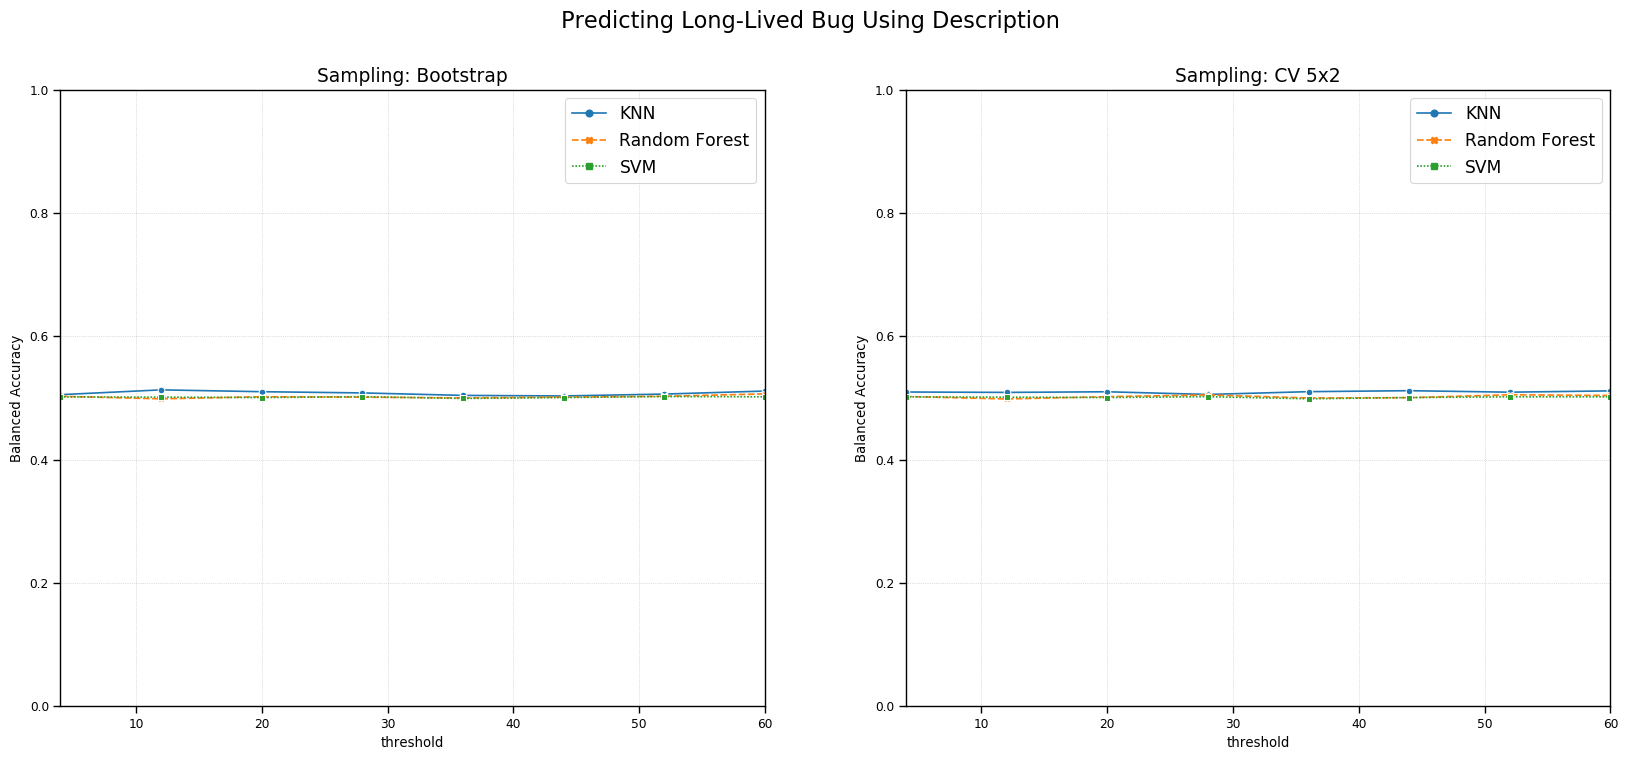

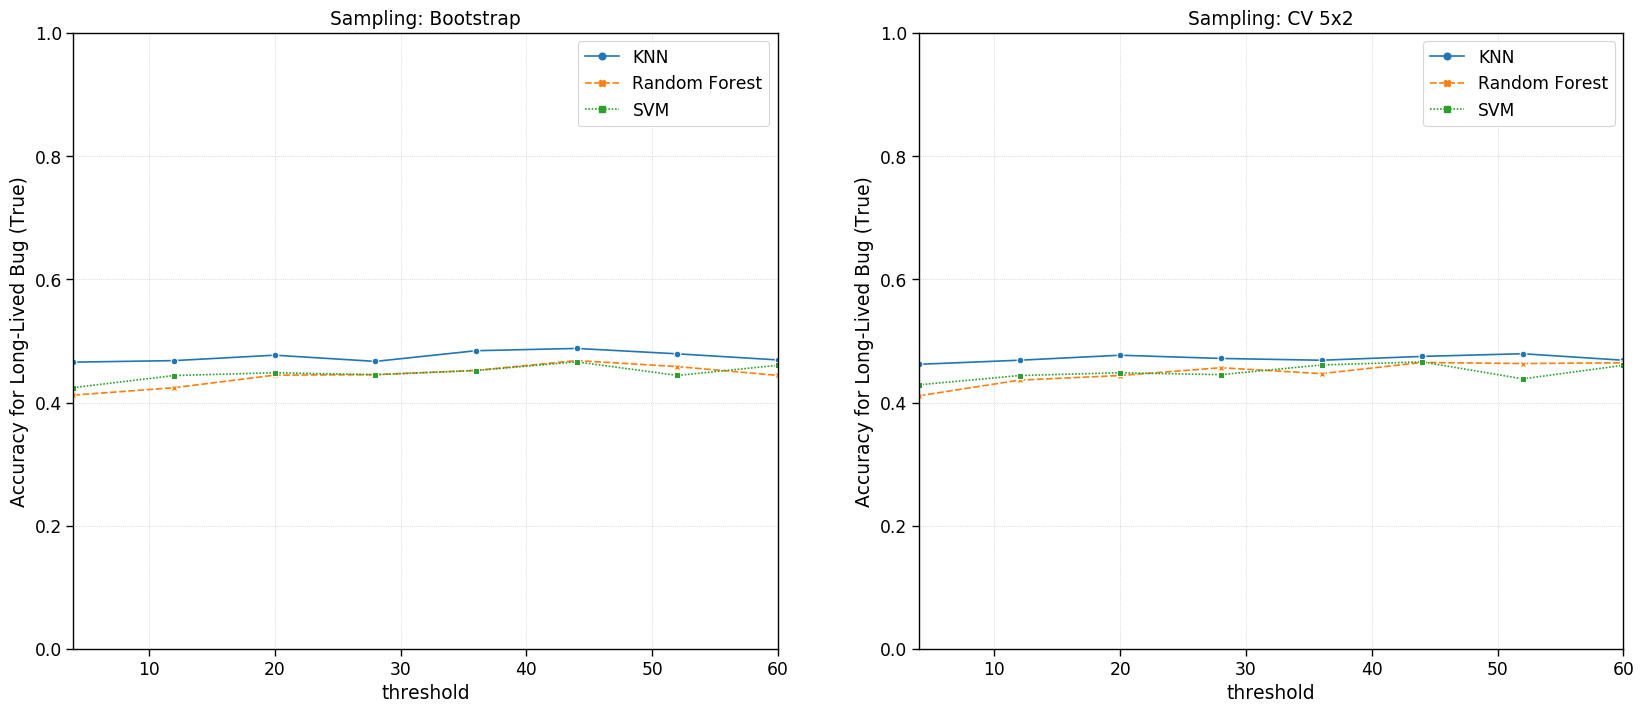

In [105]:
plot_line_by_models(results, 'Predicting Long-Lived Bug Using Description', 'long_description','balanced_acc', 'Balanced Accuracy')
plot_line_by_models(results, '', 'long_description',  'acc_class_1', 'Accuracy for Long-Lived Bug (True)')

Taking into account a reasonable threshold of up to 32 days, the **knn model** yielded the best accuracy value (**70.2%**) for both bootstrap and cross-validation.

Taking into account a reasonable threshold of up to **32 days**, the **random forest** model yielded the best accuracy values, **76.2%** for both bootstrap and **74.2%** for cross-validation resampling methods.

### Feature: Description + Summary

(<Figure size 2000x800 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a1d3be3c8>)

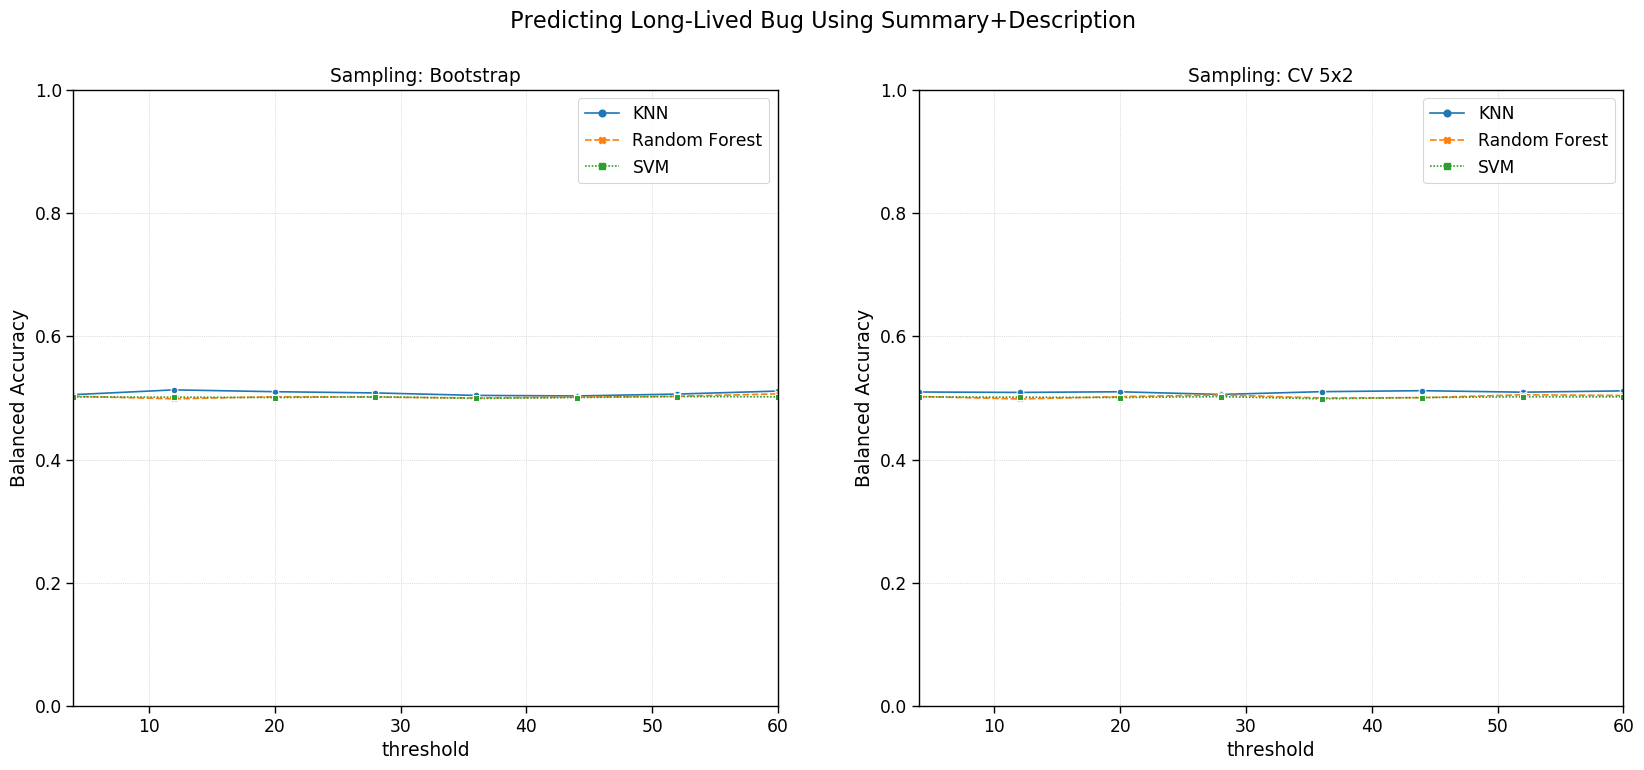

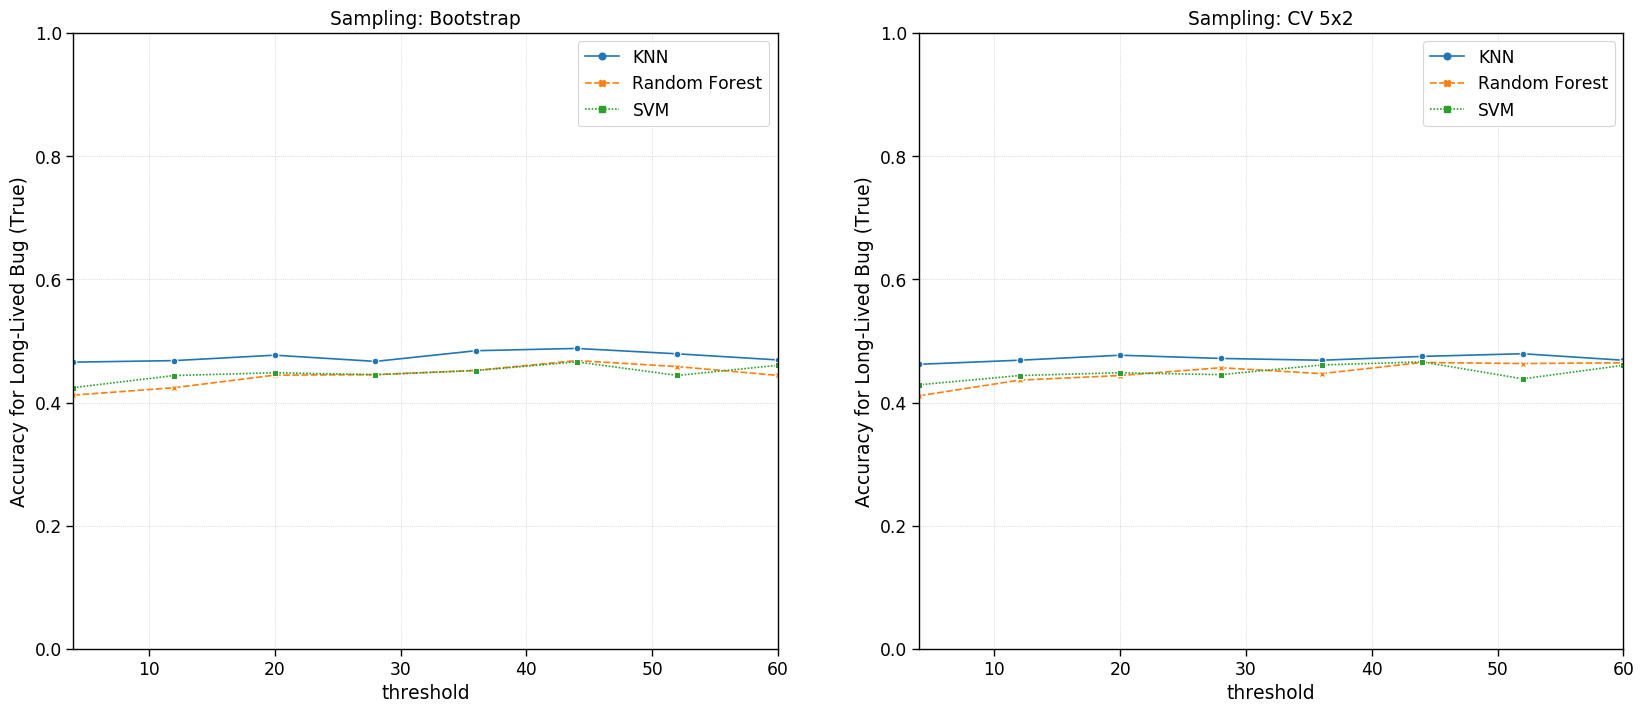

In [106]:
plot_line_by_models(results, 'Predicting Long-Lived Bug Using Summary+Description', 'short_long_description', 'balanced_acc', 'Balanced Accuracy')
plot_line_by_models(results, '', 'short_long_description', 'acc_class_1', 'Accuracy for Long-Lived Bug (True)')

### Feature: Summary

(<Figure size 2000x800 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a1d3be3c8>)

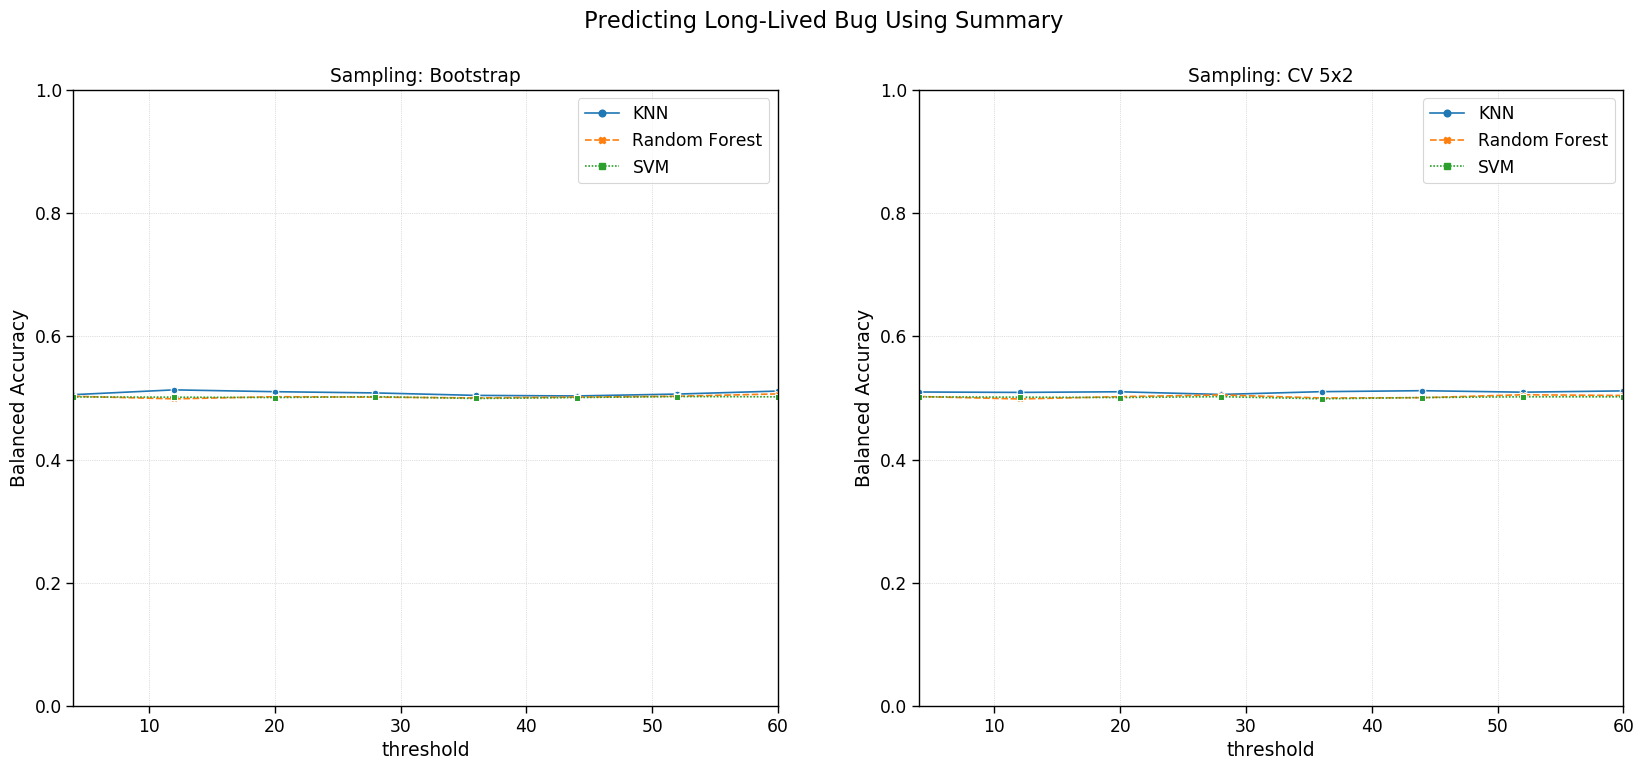

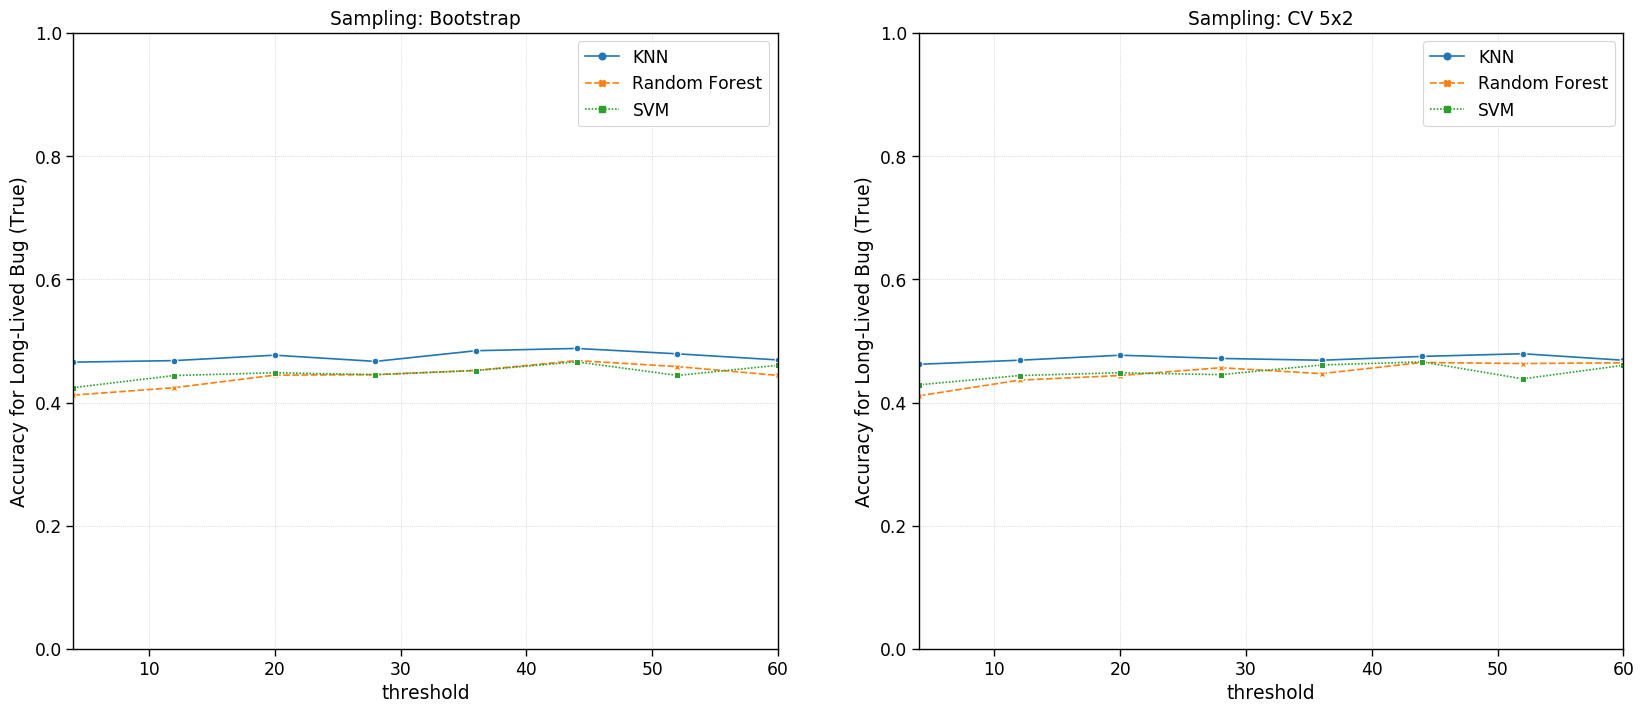

In [107]:
plot_line_by_models(results, 'Predicting Long-Lived Bug Using Summary', 'short_description', 'balanced_acc', 'Balanced Accuracy')
plot_line_by_models(results, '', 'short_description', 'acc_class_1', 'Accuracy for Long-Lived Bug (True)')

Taking into account a reasonable threshold of up to **32 days**, the **knn** model yielded the best accuracy values, **70.7**% for bootstrap and **70.6**% for cross-validation resampling methods.

### Class Ratio

KeyError: "None of [Index(['Threshold', 'Total_Ratio_Class_0', 'Total_Ratio_Class_1'], dtype='object')] are in the [columns]"

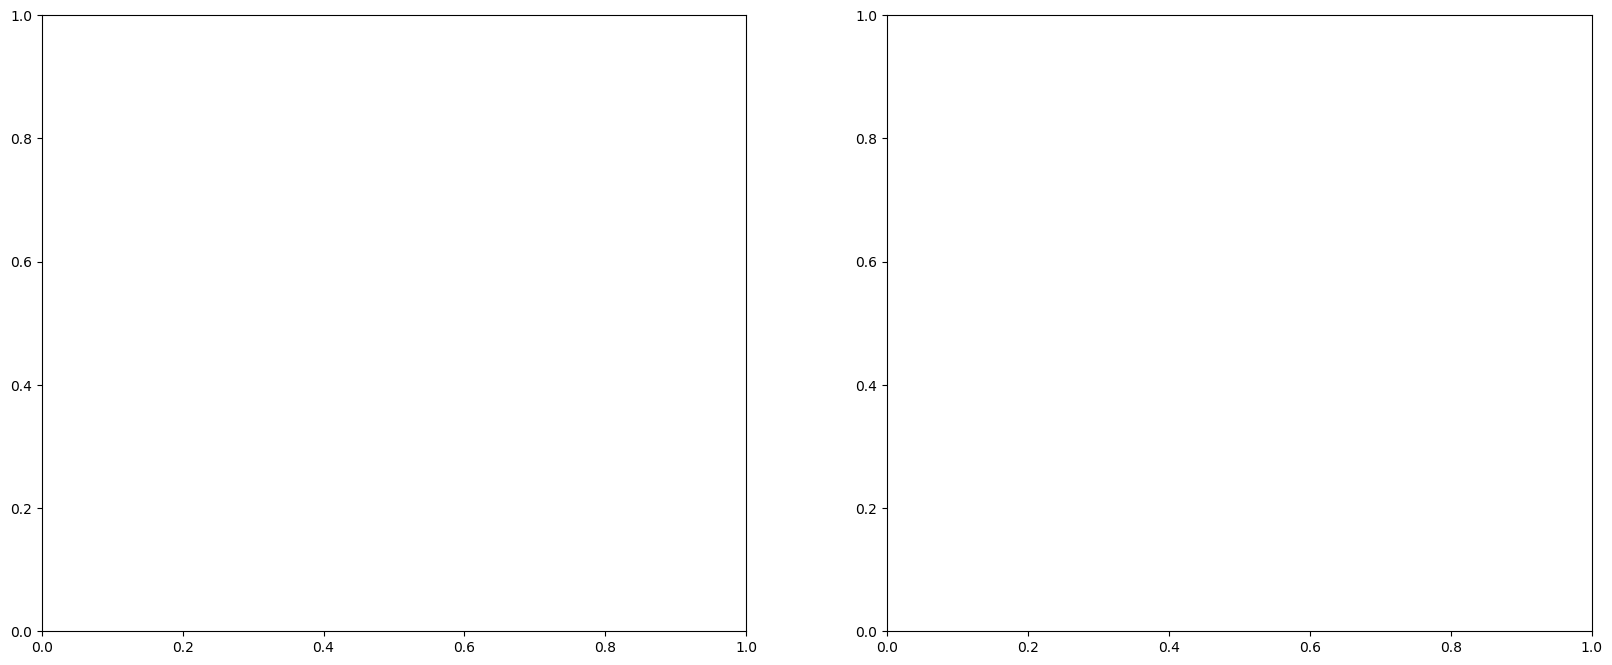

In [108]:
def plot_line_ratios(data):
    plt.style.use('default')

    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,8), sharex=True)
    ratios = results.iloc[0:8, ]
    ratios = ratios[['Threshold','Total_Ratio_Class_0','Total_Ratio_Class_1']]
   
    ratios_class_0  = ratios[['Threshold','Total_Ratio_Class_0']]
    ratios_class_1  = ratios[['Threshold','Total_Ratio_Class_1']]
    
    ratios_class_0.set_index('Threshold', inplace=True, drop=True)
    ratios_class_1.set_index('Threshold', inplace=True, drop=True)
  
    threshold_range_1 = range(4, 36, 4)
    threshold_range_2 = range(64, 534, 32)
    threshold_range   = list(threshold_range_1) + list(threshold_range_2)
    
    fig.suptitle('Class Ration')

    ax = sns.lineplot(data=ratios_class_0, markers=True, ax=axes[0])
    ax.set_ylabel('ratio')
    ax.set_ylim(0,1.0)

    ax = sns.lineplot(data=ratios_class_1, markers=True, ax=axes[1])
    ax.set_ylabel('')
    ax.set_ylim(0,1.0)
    
    return fig, ax

plot_line_ratios(results)
